# Wide and Deep Learning: Wine Price predictions

Are you able to predict the price of a certain wine bottle only from its description and region? Sincerely, I am not, but Machine learning can do it! 

In this exercise, we firstly use an ordinary/sequential Artificial Neural Network (ANNs) using Keras API and afterwards, a specific architecture of ANNs, called "Wide and Deep", to predict the wine price based on its regions and descriptions. 

                                              Marcus Duarte - 02/12/2020

                                              mvcduarte - at - gmail.com

In [1]:
# Importing some packages

import os
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn 

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

# Tensorflow

import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, concatenate

layers = keras.layers

%matplotlib inline

## 1 - The Wine Dataset  

In [2]:
# Import the dataset (randomize it and drop NaNs)

!wget -q https://storage.googleapis.com/sara-cloud-ml/wine_data.csv
df = pd.read_csv("wine_data.csv").sample(frac = 1.).dropna()

df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
6447,6447,US,"This very limited block selection is too thin,...",Tallulah's Run Reserve,85,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Coeur de Terre
41250,41250,US,"Aggressive in texture, this Syrah-based Rhône-...",Derby Vineyard Fifteen 10 Red,85,28.0,California,Paso Robles,Central Coast,Rhône-style Red Blend,Derby
24362,24362,US,"Ripe, flashy raspberry and cherry jam fruit ma...",Stone Corral Vineyard,90,50.0,California,Edna Valley,Central Coast,Pinot Noir,Talley
67341,67341,US,From a winery that names their wines after hum...,Violet-Crowned,85,18.0,California,Central Coast,Central Coast,Merlot,Clos La Chance
51459,51459,US,"Grown in one of the valley's best vineyards, i...",M5 Stagecoach Vineyard,95,150.0,California,Napa Valley,Napa,Cabernet Sauvignon,Krupp Brothers


Not that the data is roughly based on words, being columns with descriptions, regions from, variety and winery. We will use all those fields/columns as input for ANNs and predict the wine price.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39241 entries, 6447 to 116808
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   39241 non-null  int64  
 1   country      39241 non-null  object 
 2   description  39241 non-null  object 
 3   designation  39241 non-null  object 
 4   points       39241 non-null  int64  
 5   price        39241 non-null  float64
 6   province     39241 non-null  object 
 7   region_1     39241 non-null  object 
 8   region_2     39241 non-null  object 
 9   variety      39241 non-null  object 
 10  winery       39241 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 3.6+ MB


The next step is to separate those fields in the DataFrame into two classes: 

- Geographic features

- Wine descriptions (general description, variety and winery).

Note that each information class has distinct information. The first one is based on **geographic information** and the second one represents the **wine features**, such as taste, visual aspect, grape, etc. Afterwards, we separate the initial sample into training, test and validation samples.  

In [4]:
# 1st option: Combine only GEOGRAPHIC FEATURES: province, region_1, region_2 (all wines are from US) 

df['geographic_designation'] = df[['province', 'region_1', 'region_2']].agg(' '.join, axis = 1)

# 2nd option: Combine only WINE FEATURES (wine tasting, smells, etc): description + variety + winery 

df['desc_designation'] = df[['description', 'variety', 'winery']].agg(' '.join, axis = 1)

# Divide the sample into Train, Test and Validation samples 

df_train, df_test, df_validation = np.split(df, [int(.7 * df.shape[0]), int(.85 * df.shape[0])])

One the Dataframe was split into training, test and validation sample, it is necessary to transform words into numbers since ANNs do not accept directly text as input (not for this example). To do so, we use the Tokenizer function from Keras, which counts words from each document, i.e., the bag-of-words technique. At the end of the day, we have a matrix of 0s and 1, 2,.. representing each description (geographic designation or desc designation) a row and each word a respective column.  

In [5]:
# Tokenize its designation 

tokenize = keras.preprocessing.text.Tokenizer(char_level = False)
tokenize.fit_on_texts(df['geographic_designation'].values)

# Train, Test and Validation 

X_train = tokenize.texts_to_matrix(df_train['geographic_designation'].values)
y_train = df_train['price'].values
X_test = tokenize.texts_to_matrix(df_test['geographic_designation'].values)
y_test = df_test['price'].values
X_validation = tokenize.texts_to_matrix(df_validation['geographic_designation'].values)
y_validation = df_validation['price'].values

# Get list of words 

list_words = list(tokenize.word_index.keys())
print('list_words=', list_words)
print(len(list_words))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_validation.shape, y_validation.shape)

list_words= ['california', 'valley', 'sonoma', 'coast', 'central', 'napa', 'columbia', 'washington', 'oregon', 'willamette', 'wa', 'santa', 'county', 'river', 'russian', 'other', 'paso', 'robles', 'mendocino', 'hills', 'lake', 'lakes', 'finger', 'york', 'new', 'walla', 'counties', 'sierra', 'foothills', 'creek', 'dry', 'long', 'island', 'mountain', 'carneros', 'north', 'barbara', 'highlands', 'sta', 'rita', 'lucia', 'yakima', 'alexander', 'maria', 'mountains', 'ynez', 'red', 'lodi', 'monterey', 'anderson', 'of', 'district', 'edna', 'horse', 'heaven', 'fork', 'cruz', 'southern', 'dundee', 'arroyo', 'livermore', 'rutherford', 'amador', 'wahluke', 'slope', 'oakville', 'chehalem', 'el', 'dorado', 'san', 'green', 'eola', 'amity', 'grande', 'or', 'shenandoah', 'ca', 'seco', 'south', 'st', 'helena', 'howell', 'ridge', 'mount', 'veeder', 'diamond', 'knights', 'stags', 'leap', 'rogue', 'yamhill', 'luis', 'obispo', 'oak', 'knoll', 'carlton', 'temecula', 'harlan', 'umpqua', 'mt', 'chalk', 'hill',

It is important to mention that we have 208 features as input. Hey, it is a lot of features, right!? However, it is still feasible for an ordinary CPU.

## 2 - Define an ANN model 

Let's define an ANN model! For this example, we define an ANN with 1 hidden layer and a ReLU activation function (https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), as define by the Python routine below. Note that the number of neurons and the learning rate (https://en.wikipedia.org/wiki/Learning_rate) are input of the ann_model function.

In [6]:
# Define a ANN model 

def ann_model(n_col_input, n_neurons, lr):

     # Neural Network Architecture

    ann_inputs = layers.Input(shape = (n_col_input,))
    hidden1 = layers.Dense(n_neurons)(ann_inputs)
    embed_out = layers.Dense(1, activation = 'relu')(hidden1)
    ann_model = keras.Model(inputs = ann_inputs, outputs = embed_out)

    # Compile it 

    optimizer = Adam(lr = lr)
    ann_model.compile(loss = 'mse', optimizer = optimizer)

    return ann_model

Keras allows us to generate a graph of the ANN using the plot_model function.


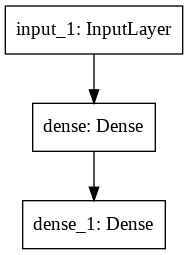

In [7]:
tf.keras.utils.plot_model(ann_model(X_train.shape[0], 30, 0.0001), to_file = 'model.png')

## 3 - Train an Artificial Neural Network

Once the text is pre-processed and the architecture of the ANN is defined, we can now train our ANN. Remember that the learning rate is one of the most important parameter of a ANN, so we will train our model and compare the performance of the trained models as a function of the learning rate. Thus, the learning rate varies from $10^{-5}$ to $10^{-3}$ and having 100 epochs. We will use a hidden layer of 128 neurons. 

lr_array= [1.e-05 1.e-04 1.e-03 1.e-02]
n_epoch= 100
Epoch 1/100
215/215 [==============================] - 1s 2ms/step - loss: 2166.6990 - val_loss: 1871.1826
Epoch 2/100
215/215 [==============================] - 0s 2ms/step - loss: 2155.1409 - val_loss: 1857.8556
Epoch 3/100
215/215 [==============================] - 0s 2ms/step - loss: 2141.0159 - val_loss: 1844.0751
Epoch 4/100
215/215 [==============================] - 0s 2ms/step - loss: 2127.1909 - val_loss: 1830.6825
Epoch 5/100
215/215 [==============================] - 0s 2ms/step - loss: 2113.5381 - val_loss: 1817.2975
Epoch 6/100
215/215 [==============================] - 0s 2ms/step - loss: 2099.8049 - val_loss: 1803.7919
Epoch 7/100
215/215 [==============================] - 0s 2ms/step - loss: 2085.8508 - val_loss: 1789.9875
Epoch 8/100
215/215 [==============================] - 0s 2ms/step - loss: 2071.6079 - val_loss: 1775.9185
Epoch 9/100
215/215 [==============================] - 0s 2ms/step - loss: 2057.0337 - val_

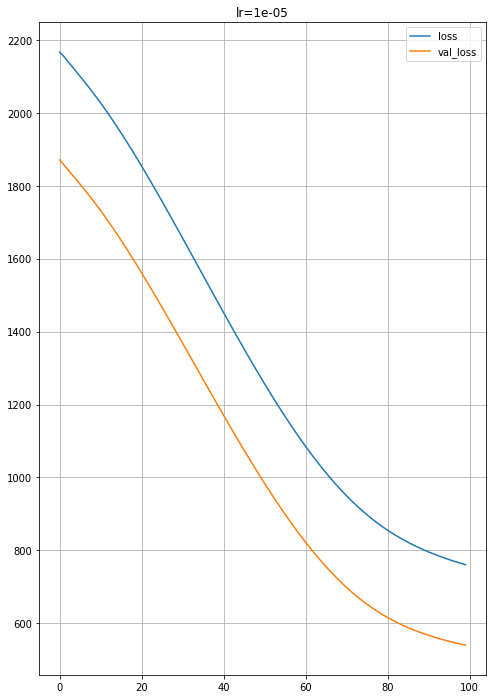

*******************************************************************
Epoch 1/100
215/215 [==============================] - 0s 2ms/step - loss: 2105.2029 - val_loss: 1737.3705
Epoch 2/100
215/215 [==============================] - 0s 2ms/step - loss: 1931.5623 - val_loss: 1545.1896
Epoch 3/100
215/215 [==============================] - 0s 2ms/step - loss: 1712.8868 - val_loss: 1315.9725
Epoch 4/100
215/215 [==============================] - 0s 2ms/step - loss: 1472.4609 - val_loss: 1085.2578
Epoch 5/100
215/215 [==============================] - 0s 2ms/step - loss: 1246.4338 - val_loss: 886.7392
Epoch 6/100
215/215 [==============================] - 0s 2ms/step - loss: 1062.3982 - val_loss: 739.1124
Epoch 7/100
215/215 [==============================] - 0s 2ms/step - loss: 931.3817 - val_loss: 643.5045
Epoch 8/100
215/215 [==============================] - 0s 2ms/step - loss: 847.5095 - val_loss: 586.9143
Epoch 9/100
215/215 [==============================] - 0s 2ms/step - loss: 796.234

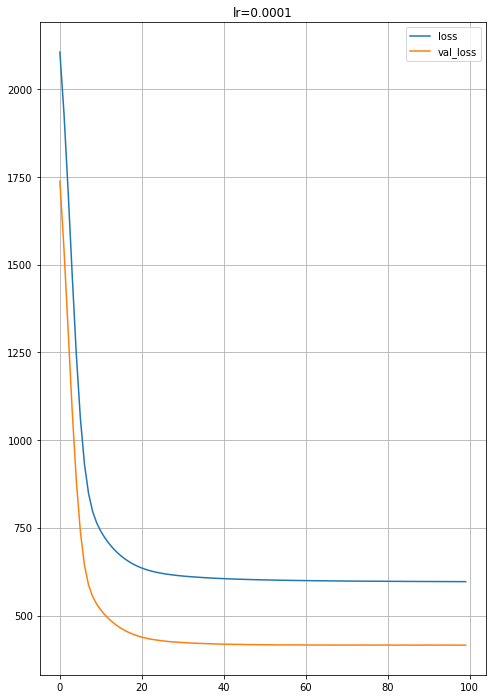

*******************************************************************
Epoch 1/100
215/215 [==============================] - 0s 2ms/step - loss: 1338.3992 - val_loss: 540.1878
Epoch 2/100
215/215 [==============================] - 0s 2ms/step - loss: 690.0695 - val_loss: 448.7285
Epoch 3/100
215/215 [==============================] - 0s 2ms/step - loss: 628.8743 - val_loss: 427.0240
Epoch 4/100
215/215 [==============================] - 0s 2ms/step - loss: 612.1712 - val_loss: 420.8753
Epoch 5/100
215/215 [==============================] - 0s 2ms/step - loss: 606.0720 - val_loss: 418.8501
Epoch 6/100
215/215 [==============================] - 0s 2ms/step - loss: 603.0500 - val_loss: 417.3709
Epoch 7/100
215/215 [==============================] - 0s 2ms/step - loss: 601.1907 - val_loss: 416.6082
Epoch 8/100
215/215 [==============================] - 0s 2ms/step - loss: 600.0980 - val_loss: 416.0587
Epoch 9/100
215/215 [==============================] - 0s 2ms/step - loss: 599.0731 - val_l

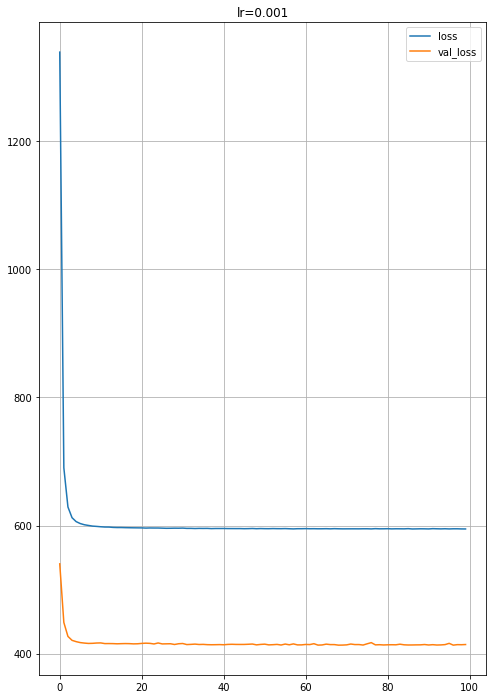

*******************************************************************
Epoch 1/100
215/215 [==============================] - 0s 2ms/step - loss: 720.7117 - val_loss: 422.0029
Epoch 2/100
215/215 [==============================] - 0s 2ms/step - loss: 605.5895 - val_loss: 422.7394
Epoch 3/100
215/215 [==============================] - 0s 2ms/step - loss: 605.0797 - val_loss: 419.8607
Epoch 4/100
215/215 [==============================] - 0s 2ms/step - loss: 602.7526 - val_loss: 424.3793
Epoch 5/100
215/215 [==============================] - 0s 2ms/step - loss: 602.2096 - val_loss: 418.4797
Epoch 6/100
215/215 [==============================] - 0s 2ms/step - loss: 601.8780 - val_loss: 417.3730
Epoch 7/100
215/215 [==============================] - 0s 2ms/step - loss: 603.5444 - val_loss: 416.2615
Epoch 8/100
215/215 [==============================] - 0s 2ms/step - loss: 600.6567 - val_loss: 422.2333
Epoch 9/100
215/215 [==============================] - 0s 2ms/step - loss: 600.3508 - val_lo

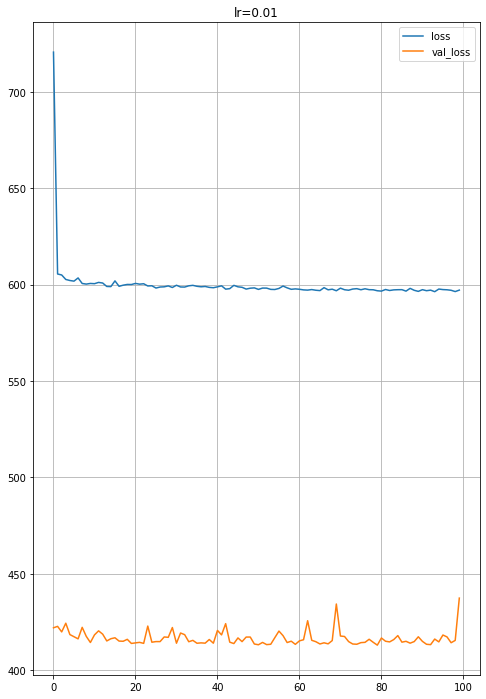

*******************************************************************
mse_lr_array= [678.8551261587639, 510.9710826086796, 507.3916650229894, 525.4474443788954]


In [8]:
lr_array = 10**np.array([-5., -4., -3., -2.])
n_epoch = 100
print('lr_array=', lr_array)
print('n_epoch=', n_epoch)

mse_lr_array = []
dic_y_pred = {}
for i_lr, lr in enumerate(lr_array):

    model_ann = ann_model(X_train.shape[1], 128, lr)

    tf.keras.utils.plot_model(model_ann, to_file = 'model' + str(i_lr) + '.png')

    # Fit

    history = model_ann.fit(X_train, y_train, 
                            epochs = n_epoch,
                            validation_data = (X_validation, y_validation),
                            batch_size = 128)

    y_pred = model_ann.predict(X_test)
    dic_y_pred[i_lr] = y_pred

    # Calculate MSE 

    mse_lr_array.append(mean_squared_error(y_pred, y_test))

    print('MSE and ave(diff)=', mean_squared_error(y_pred, y_test), np.average(y_pred - y_test))

    # Plot it 

    pd.DataFrame(history.history).plot(figsize=(8, 12))
    plt.title('lr=' + str(lr))
    plt.grid()
    plt.show()
    #plt.savefig('loss_lr' + str(lr) + '.png')
    print('*******************************************************************')

print('mse_lr_array=', mse_lr_array)


Next, we plot the MSE as a function of the learning rate. It is important to mention that the best learning rate is bewtween $10^{ -4}$ and $10^{-3}$. 

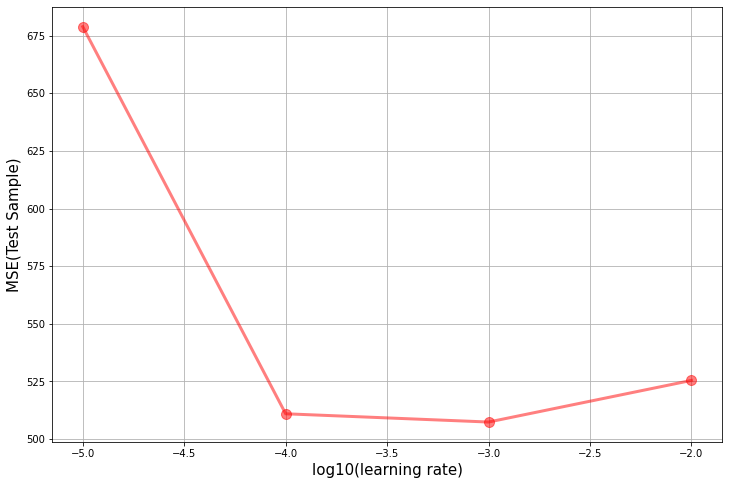

In [9]:
fig = plt.figure(figsize = (12, 8))
plt.plot(np.log10(lr_array), mse_lr_array, '-o', markersize = 10, lw = 3, color = 'red', alpha = 0.5)
plt.ylabel('MSE(Test Sample)', fontsize = 15)
plt.xlabel('log10(learning rate)', fontsize = 15)
plt.grid()

How about if we include the desc_designation as features, in the same way we did with geographic ones?

In [10]:
# Create a tokenizer to pre-process our ocean_proximity descriptions

tokenize_desc = keras.preprocessing.text.Tokenizer(char_level = False)
tokenize_desc.fit_on_texts(df_train['desc_designation'].values)

desc_train = tokenize_desc.texts_to_matrix(df_train['desc_designation'].values)
desc_test = tokenize_desc.texts_to_matrix(df_test['desc_designation'].values)
desc_validation = tokenize_desc.texts_to_matrix(df_validation['desc_designation'].values)

list_words_desc = list(tokenize_desc.word_index.keys())
print('list_words_desc=', list_words_desc)
print(desc_train.shape, X_train.shape)

list_words_desc= ['and', 'the', 'a', 'of', 'with', 'this', 'in', 'is', 'flavors', 'wine', 'it', 'to', "it's", 'fruit', 'but', 'pinot', 'blend', 'that', 'cabernet', 'cherry', 'red', 'dry', 'noir', 'for', 'sauvignon', 'tannins', 'oak', 'from', 'on', 'acidity', 'finish', 'chardonnay', 'now', 'rich', 'sweet', 'are', 'has', 'black', 'ripe', 'syrah', 'an', 'its', 'as', 'very', 'drink', 'style', 'shows', 'blackberry', 'good', 'soft', 'vanilla', 'cherries', 'years', 'vineyard', 'palate', 'chocolate', 'like', 'not', 'merlot', 'zinfandel', 'spice', 'by', 'some', 'more', 'at', 'notes', 'well', 'raspberry', 'tannic', 'cola', 'aromas', 'crisp', 'pepper', 'bordeaux', 'into', 'all', 'complex', 'full', 'one', 'white', 'bit', 'dark', 'fine', 'or', 'be', 'new', 'tart', 'little', 'just', 'alcohol', 'through', 'blanc', 'so', 'smoky', 'spicy', 'blackberries', 'you', "there's", 'bodied', 'made', 'will', 'currant', 'best', 'should', 'light', 'berry', 'up', 'balanced', 'green', 'which', 'delicious', 'texture'

WOW! It is a matrix with 17958 columns, then we need a sequential ANN much larger than those we have now! How do we process all this additional data?
One approach is the Wide and Deep Learning. 

# Wide & Deep Learning

Wide and Deep learning is a certain configuration/architecture of neural networks that combines linear models (generalization and memorization) and deep learning (detailed characteristics) in one model. One can train a wide linear model in parallel with a deep neural network at once. it can be quite useful for large number of features as inputs for regression and classification systems, such as recommender systems.

In [11]:
# Wide Model

wide = Input(shape = (desc_train.shape[1],))

# Deep Model

n_col_input = X_train.shape[1]
deep_data = Input(shape = (n_col_input,))
deep1 = Dense(128, activation = 'relu')(deep_data)
deep = Dense(1)(deep1)

# Wide & Deep

wide_deep = concatenate([wide, deep])
wide_deep_out = Dense(1, activation = 'relu')(wide_deep)
model = Model(inputs = [wide, deep_data], outputs = wide_deep_out)

The architecture of the Wide and Deep Neural Network is represented below. The desc_designation (more than 17k features) enters in the model in the last layer before the output layer. It means that it will not pass throurgh the ANN model, saving a lot of computational time.  

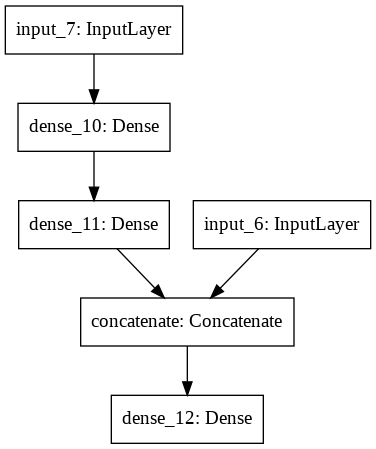

In [12]:
tf.keras.utils.plot_model(model, to_file = 'model_wide_deep.png')

lr= 0.01
n_epoch= 100
Epoch 1/100
859/859 [==============================] - 4s 5ms/step - loss: 934.7401 - val_loss: 396.4046
Epoch 2/100
859/859 [==============================] - 4s 4ms/step - loss: 564.2082 - val_loss: 356.1542
Epoch 3/100
859/859 [==============================] - 4s 4ms/step - loss: 529.9504 - val_loss: 335.2309
Epoch 4/100
859/859 [==============================] - 4s 4ms/step - loss: 507.6189 - val_loss: 320.0244
Epoch 5/100
859/859 [==============================] - 4s 4ms/step - loss: 490.9713 - val_loss: 308.6421
Epoch 6/100
859/859 [==============================] - 4s 4ms/step - loss: 477.6374 - val_loss: 300.7713
Epoch 7/100
859/859 [==============================] - 4s 4ms/step - loss: 467.1220 - val_loss: 293.0355
Epoch 8/100
859/859 [==============================] - 4s 4ms/step - loss: 458.1153 - val_loss: 288.8648
Epoch 9/100
859/859 [==============================] - 4s 4ms/step - loss: 450.6811 - val_loss: 282.7373
Epoch 10/100
859/859 [===========

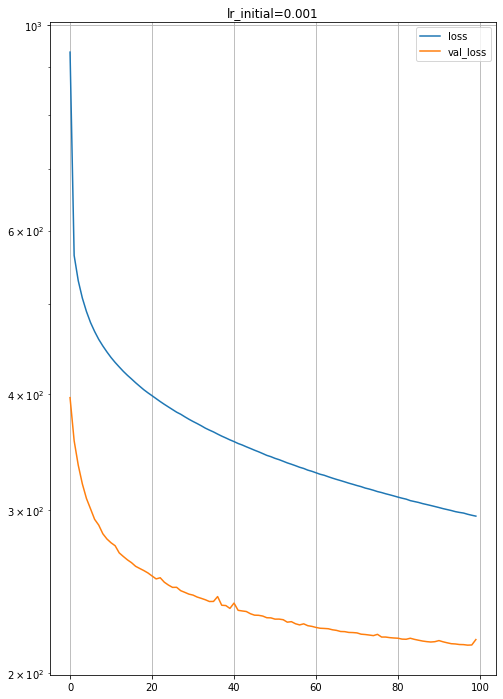

In [13]:

lr_initial = 0.001 # learning rate
n_epoch = 100     # number of epochs
print('lr=', lr)
print('n_epoch=', n_epoch)

# Compile the Keras model API 

optimizer = Adam(learning_rate = lr_initial)
model.compile(optimizer = optimizer, loss = 'mse')

# Fit 

history = model.fit([desc_train, X_train], y_train, 
                    validation_data = ([desc_validation, X_validation], y_validation),
                    epochs = n_epoch, verbose = 1)

print('MSE(test)=', model.evaluate([desc_test, X_test], y_test))

# Plot it 

pd.DataFrame(history.history).plot(figsize=(8, 12), logy = True)
plt.title('lr_initial=' + str(lr_initial))
plt.grid()
plt.show()

In [14]:
y_pred = model.predict([desc_test, X_test])

print('MSE(Test)(ANN)=', mean_squared_error(y_pred, y_test))

print('MSE(Test)(Wide and Deep)=', mean_squared_error(y_pred, dic_y_pred[1]))


MSE(Test)(ANN)= 277.92825791883394
MSE(Test)(Wide and Deep)= 208.98535


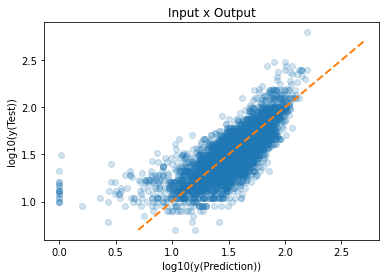

In [15]:
plt.plot(np.log10(y_pred + 1.), np.log10(y_test + 1.), 'o', alpha = 0.2)
x = np.arange(min(np.log10(y_test + 1.)), max(np.log10(y_test + 1.)))
plt.plot(x, x, '--', lw = 2.)
plt.ylabel('log10(y(Test))')
plt.xlabel('log10(y(Prediction))')
plt.title('Input x Output')
plt.show()

## Conclusions

A Artificial Neural Network is an interesting model to predict the wine price for the chosen dataset. However, if one decides to include more information, besides the geographic one, the ANN model can be quite slow due to the huge number of input features and your computational time explodes. One alternative to circumvent this problem is to use Wide and Deep models, which is able to memorize (linear model) and generalizations (deep models) and at the same time. Comparing the performance of both models, we can notice that the MSE for ANN and Wide and Deep (WD) model are $\sim$277 and $\sim$208, respectively. It indicates that the WD includes more information as input and consequently improves the performance, and at the same time roughly keeps the computational time.    

## Improvements

- The validation loss is below the training loss. It can indicates that those samples are not restrictly representative of each other. 

- Some training and validation loss curves are quite noisy, maybe we need to pay a bit with the architecture or parameters of both models. 

- Include the column "winery" in the bag-of-words and check if the model performance really improves. 

- Use the TF-IDF (https://en.wikipedia.org/wiki/Tf%E2%80%93idf) instead of bag-of-words and check the performance. 

- Remove "stop words" to remove the unnecessary features. 
